# Train the autoencoder with the whole dataset using generators

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg

2023-03-18 19:15:31.342438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Initialize the generator and verify that it works

In [2]:
batch_size = 400
gen_input = dg.SunImgAEGenerator("data/aia_193A/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)

(9, 1, 1) (9, 1, 1) (9, 1, 1)


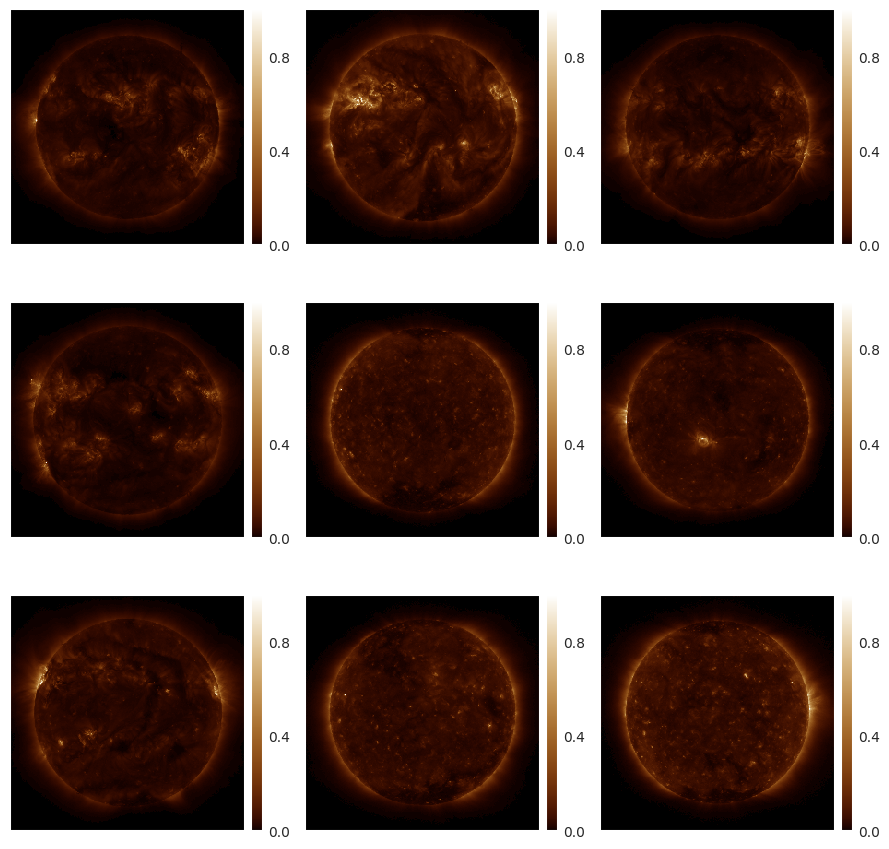

In [3]:
aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
samples = gen_input.sample(9)
isns.ImageGrid([i for i in samples], cmap=aia193_colormap)

## Create and train the model

In [4]:
latent_size = 48
autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim="adam", loss="mse")

2023-03-18 14:29:58.839382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 14:29:58.851841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 14:29:58.852001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 14:29:58.852385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      2320      
                                                             

In [5]:
n_epochs = 100

gen_input.training = True
history = autoencoder.fit(gen_input, epochs=n_epochs)

Epoch 1/100


2023-03-18 14:30:06.500963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-18 14:30:08.577841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-18 14:30:09.368926: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-18 14:30:09.539339: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-18 14:30:11.219610: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0

45/45 [==============================] - 146s 3s/step - loss: 0.0025 - mae: 0.0283
Epoch 2/100
45/45 [==============================] - 114s 3s/step - loss: 0.0015 - mae: 0.0191
Epoch 3/100
45/45 [==============================] - 115s 3s/step - loss: 0.0013 - mae: 0.0168
Epoch 4/100
45/45 [==============================] - 113s 2s/step - loss: 0.0012 - mae: 0.0156
Epoch 5/100
45/45 [==============================] - 112s 2s/step - loss: 0.0011 - mae: 0.0149
Epoch 6/100
45/45 [==============================] - 112s 2s/step - loss: 0.0011 - mae: 0.0155
Epoch 7/100
45/45 [==============================] - 112s 2s/step - loss: 0.0010 - mae: 0.0141
Epoch 8/100
45/45 [==============================] - 112s 2s/step - loss: 0.0010 - mae: 0.0141
Epoch 9/100
45/45 [==============================] - 112s 2s/step - loss: 9.8104e-04 - mae: 0.0139
Epoch 10/100
45/45 [==============================] - 113s 2s/step - loss: 9.3324e-04 - mae: 0.0136
Epoch 11/100
45/45 [==============================] -

## Save the model to a file

In [6]:
autoencoder.save("autoencoder_193A.h5")
encoder.save("encoder_193A.h5")
decoder.save("decoder_193A.h5")

## Test model and see how it progressed

45/45 [==============================] - 126s 3s/step - loss: 5.8116e-04 - mae: 0.0109


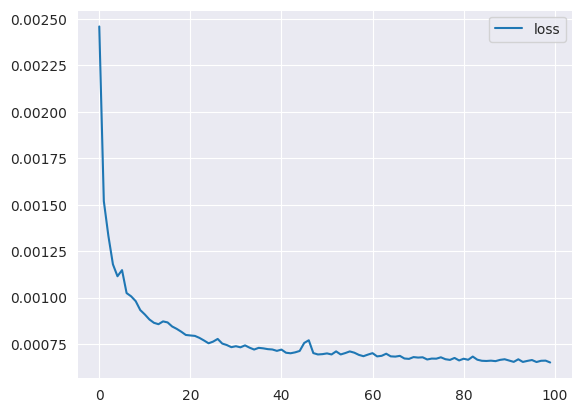

In [7]:
gen_input.training = False
autoencoder.evaluate(gen_input)
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 100ms/step


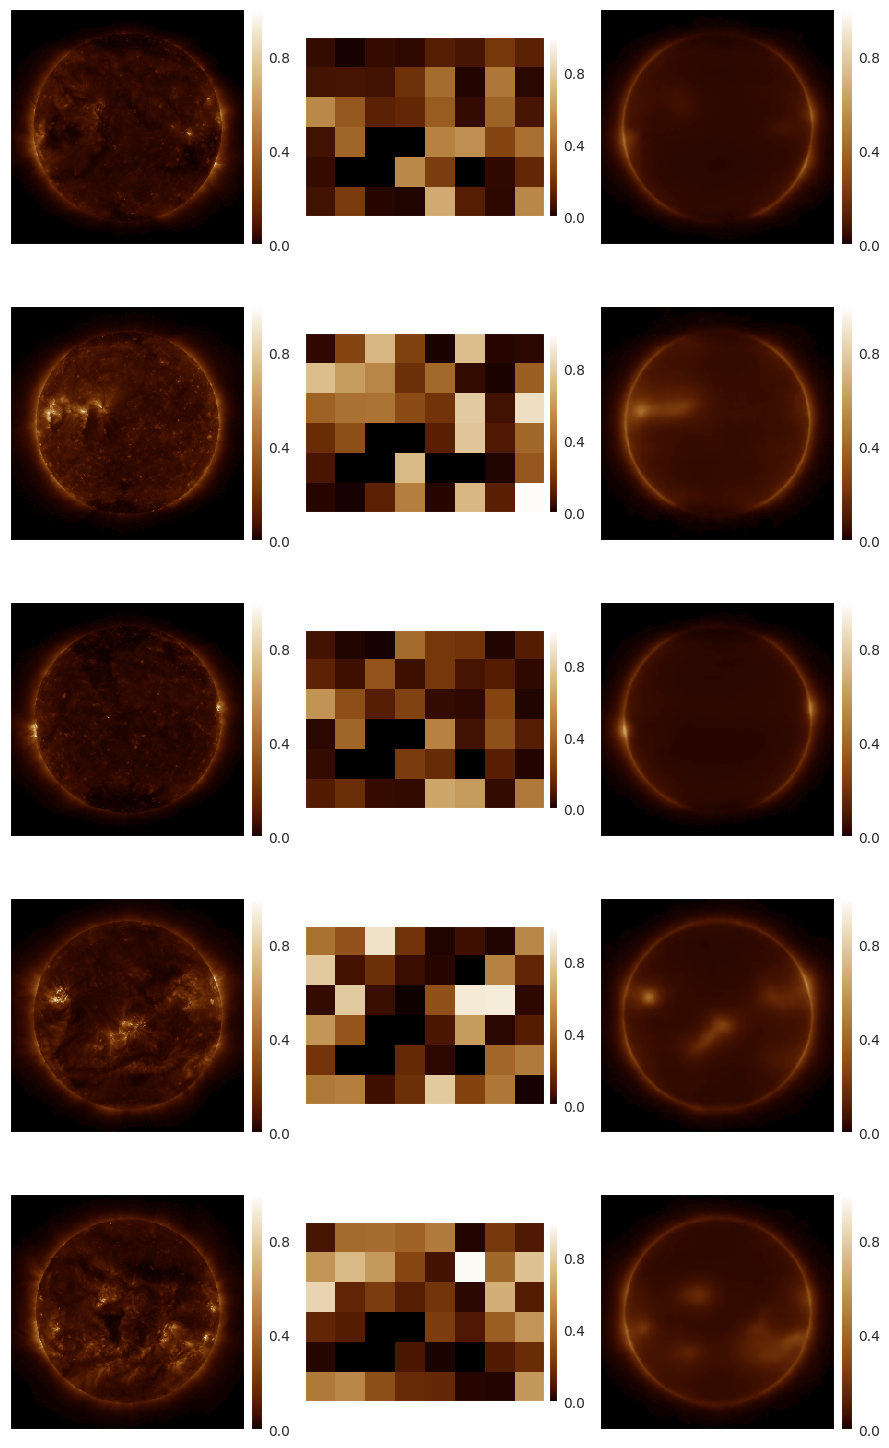

In [41]:
gen_input.training = False
example = np.array(gen_input[0]).reshape([-1,256,256,1])[:5]
code = encoder.predict(example)
reconstructed = decoder.predict(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1)

In [4]:
autoencoder = keras.models.load_model("autoencoder_193A.h5")
encoder = keras.models.load_model("encoder_193A.h5")
decoder = keras.models.load_model("decoder_193A.h5")
all_data_gen = dg.SunImgAEGenerator("data/aia_193A/", batch_size, test_split=0.2, shuffle=True, noise_filter=False)

2023-03-18 19:15:43.735026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:15:43.835626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:15:43.835816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:15:43.836995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

(5, 1, 1) (5, 1, 1) (5, 1, 1)


2023-03-18 19:15:46.575215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


1/1 [==============================] - 2s 2s/step


2023-03-18 19:15:47.686986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


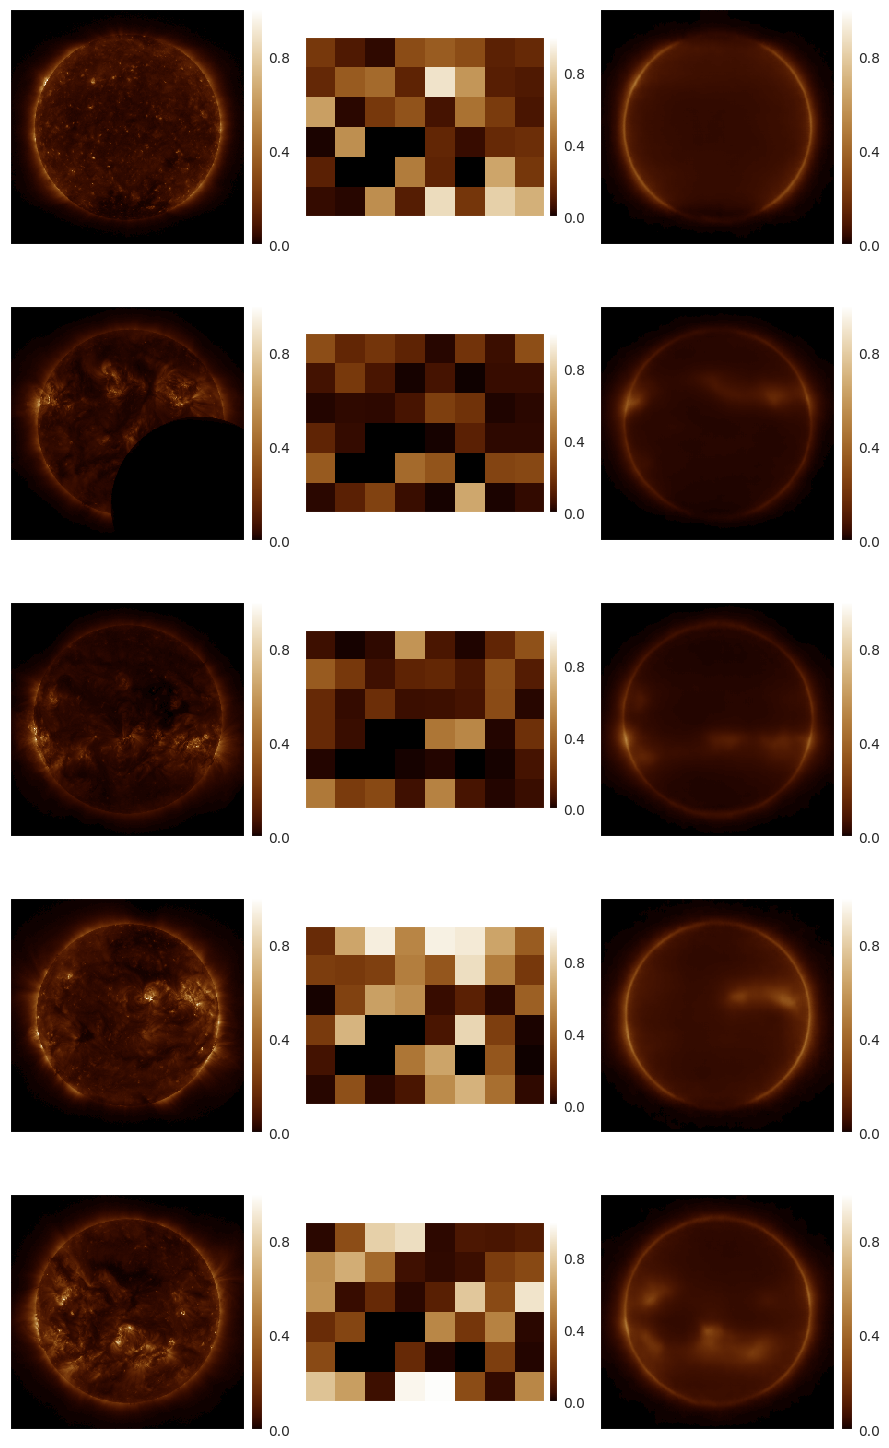

In [5]:
gen_input.take_all = True
example = all_data_gen.sample(5)
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1)

## Test the autoencoder with random inputs

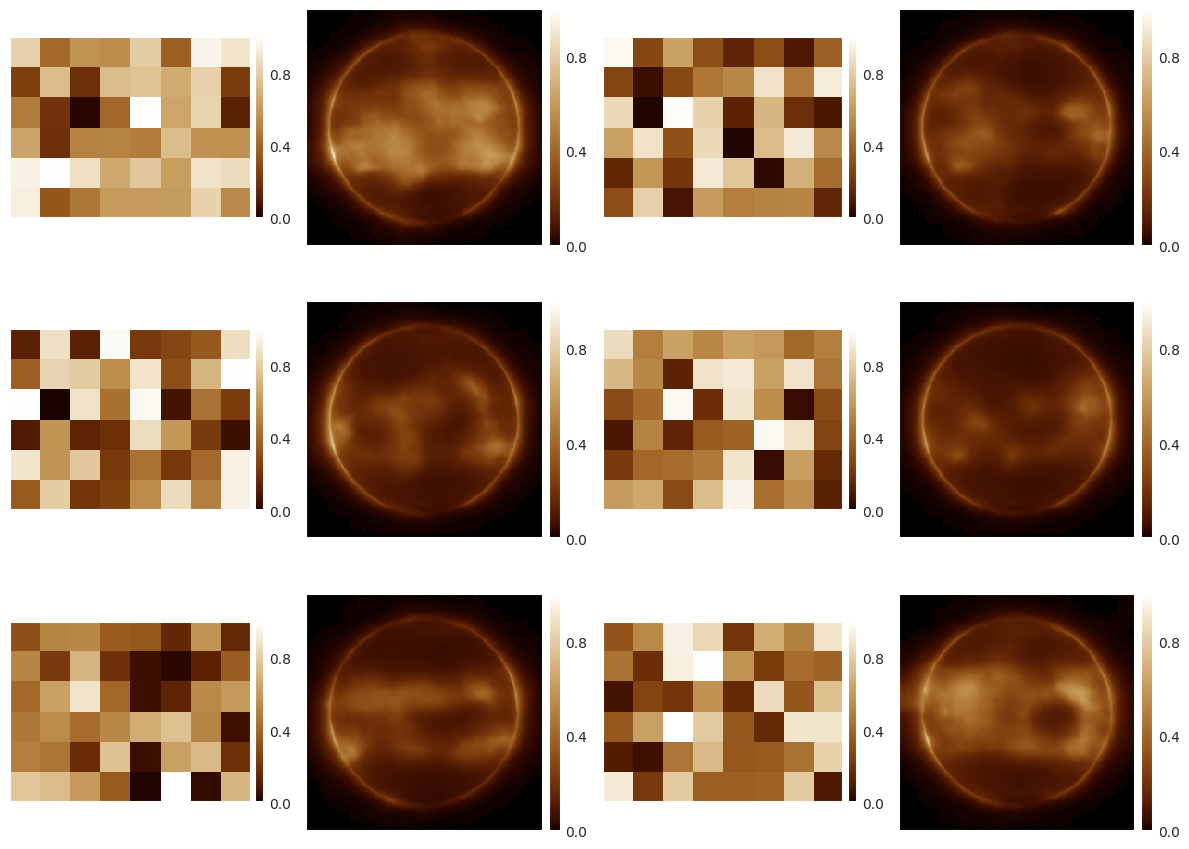

In [7]:
code = np.random.random([6, 48])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [6,8]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=4)